#Работа нашей модели для определния объектов, неучтенных в реестре.

Импорт библиотек

In [1]:
# import the necessary libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###Подгружаем доступ к нашей модели

In [2]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="API_KEY")
project = rf.workspace().project("gpsbuildingdetection")
model = project.version(2).model

# infer on a local image
output = model.predict("test.jpg", confidence=50).json()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 803.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninst

loading Roboflow workspace...
loading Roboflow project...


### Функция подсчета площади по координатам полигона здания

In [3]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

### Поиск здания в кадастровом файле

In [8]:
def findObject(coordinates, file):
  for index, row in file.iterrows():
    if coordinates[0] <= row['coordinate_x'] <= coordinates[1] and coordinates[2] <= row['coordinate_y'] <= coordinates[3]:
      return row['name']
  return False

#Поиск контуров здания и их площадей

In [5]:
boxes = []
areas = []
for bounding_box in output['predictions']:
    x1 = bounding_box['x'] - bounding_box['width'] / 2
    x2 = bounding_box['x'] + bounding_box['width'] / 2
    y1 = bounding_box['y'] - bounding_box['height'] / 2
    y2 = bounding_box['y'] + bounding_box['height'] / 2
    #calculate box
    boxes.append((int(x1), int(x2), int(y1), int(y2)))
    #calculate area by polygon
    x_list = [int(pair['x']) for pair in bounding_box['points']]
    y_list = [int(pair['y']) for pair in bounding_box['points']]
    areas.append(PolyArea(np.array(x_list), np.array(y_list)))

Удаляем неверно определившийся дом

In [6]:
ind = boxes.index((163, 197, 40, 102))
boxes.remove((163, 197, 40, 102))
del areas[ind]

##Выделяем зелеными квадратами здания, которые есть в реестре и красными, которых нет.

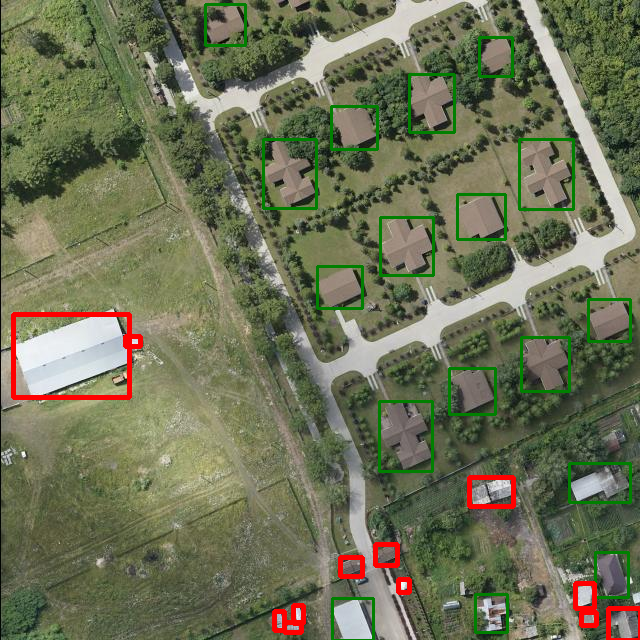

True

In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

file_kadastr = pd.read_csv("kadastr.csv")
img_rgb = cv.imread('test.jpg')
color_true = (0, 128, 0)  #green
color_false = (0, 0, 255) #red
thickness = 2
for box in boxes:
    #print(box)
    result = findObject(box, file_kadastr)
    if result:
      img_rgb = cv.rectangle(img_rgb, (box[0],box[2]), (box[1],box[3]), color_true, thickness)
    else:
      img_rgb = cv.rectangle(img_rgb, (box[0],box[2]), (box[1],box[3]), color_false, thickness+1)
cv2_imshow(img_rgb)
cv.imwrite("test_out.jpg", img_rgb)